In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.api import ARIMA

import pmdarima as pm

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## ARIMA using eye-balling

In [5]:
df1 = pd.read_csv('airline_passengers.csv', index_col =  'Month', parse_dates = True)
df1.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


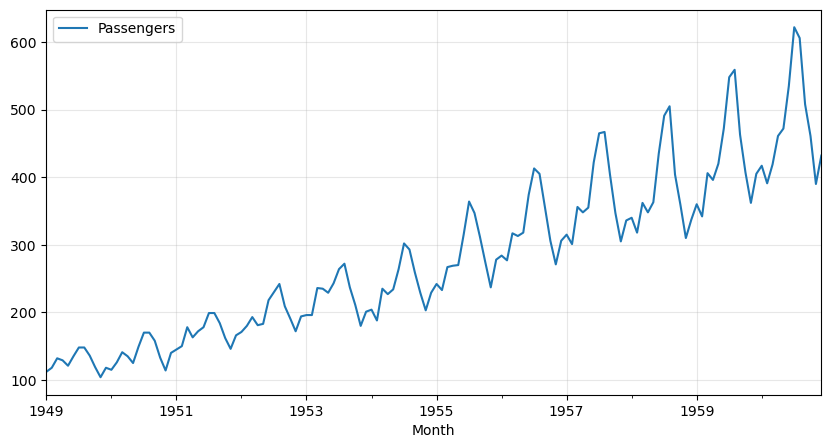

In [11]:
df1.plot(figsize = (10, 5))
plt.grid(True, alpha = 0.3);

In [7]:
# Def a function to check stationarity for further works

def check_stationarity(series):
    """
    Check the stationarity of a time series using ADF and KPSS tests.
    ADF H0: non-stationary -> high p-value (> 0.05) = non-stationary
    KPSS H0: stationary -> low p-value (< 0.05) = non-stationary
    """
    # Perform Augmented Dickey-Fuller test
    adf_result = adfuller(series.dropna())
    adf_p_value = adf_result[1]  # Extract p-value from ADF test; if we want test statistic then it is [0]

    # Perform KPSS test
    kpss_result = kpss(series.dropna(), regression='c')
    kpss_p_value = kpss_result[1]  # Extract p-value from KPSS test

    # ADF Test Conclusion
    if adf_p_value < 0.05:
        adf_conclusion = "The series is stationary based on the ADF test (p-value < 0.05)."
    else:
        adf_conclusion = "The series is non-stationary based on the ADF test (p-value >= 0.05)."

    # KPSS Test Conclusion
    if kpss_p_value < 0.05:
        kpss_conclusion = "The series is non-stationary based on the KPSS test (p-value < 0.05)."
    else:
        kpss_conclusion = "The series is stationary based on the KPSS test (p-value >= 0.05)."

    # Print test results and conclusions
    print(f"ADF Test: p-value = {adf_p_value:.5f}")
    print(adf_conclusion)
    print(f"KPSS Test: p-value = {kpss_p_value:.5f}")
    print(kpss_conclusion)

    # return {'ADF': adf_p_value, 'ADF Conclusion': adf_conclusion, 'KPSS': kpss_p_value, 'KPSS Conclusion': kpss_conclusion}

In [9]:
check_stationarity(df1.Passengers)

ADF Test: p-value = 0.99188
The series is non-stationary based on the ADF test (p-value >= 0.05).
KPSS Test: p-value = 0.01000
The series is non-stationary based on the KPSS test (p-value < 0.05).


* So we need to apply Differencing. Let's def another one to check the proper order.

In [14]:
def difference_until_pass_kpss(time_series, max_diff=3, significance_level=0.05):
    """
    Perform differencing on the time series until it passes the KPSS test for stationarity
    or until the maximum number of differencing steps (max_diff) is reached.

    Parameters:
    - time_series: The original time series (pandas Series).
    - max_diff: The maximum number of differencing steps to apply.
    - significance_level: The significance level for the KPSS test (default is 0.05).

    Prints:
    - A message indicating whether the series became stationary or failed the KPSS test.
    """

    # Sub-function to perform the KPSS test
    def kpss_test(ts):
        """Run KPSS test on the time series and return whether it passes the test (stationary)."""
        statistic, p_value, _, _ = kpss(ts, regression='c', nlags="auto")
        return p_value > significance_level  # If p-value is greater than significance level, the series is stationary

    d = 0  # Initialize differencing count
    diff_series = time_series.copy()

    # Loop to difference and test for stationarity using KPSS
    while d <= max_diff:
        if kpss_test(diff_series):
            print(f"Series became stationary after {d} differencing(s).")
            break  # Stop further execution if series is stationary
        else:
            d += 1
            if d <= max_diff:
                diff_series = diff_series.diff().dropna()  # Apply differencing internally

    # If the loop ends without the series becoming stationary
    if d > max_diff:
        print(f"The series fails the KPSS test at d = {max_diff}.")

In [16]:
difference_until_pass_kpss(df1.Passengers)

Series became stationary after 1 differencing(s).


* So d = 1 is a good candidate in the optimal model.
* Let apply Differencing once, then use ACF and PACF to see some patterns if any.

In [23]:
df1['Passengers_Diff'] = df1.Passengers.diff()

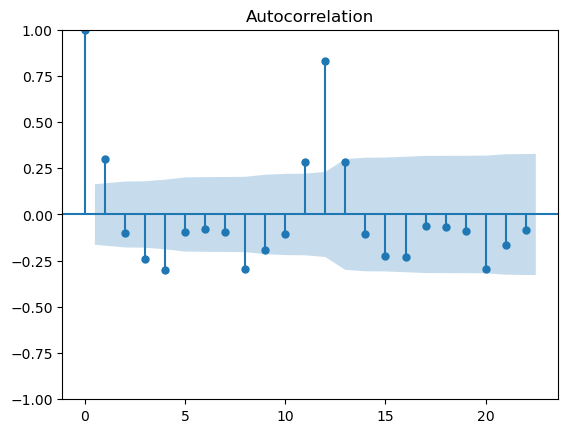

In [25]:
plot_acf(df1['Passengers_Diff'].dropna());

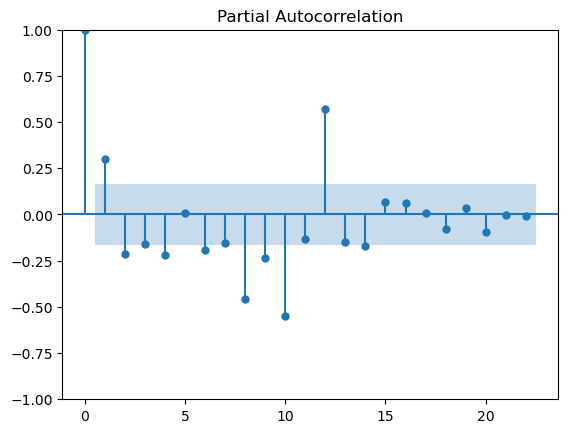

In [27]:
plot_pacf(df1['Passengers_Diff'].dropna());

* Lag 12 is a good candidate to set the orders for AR and MA components.
* Because in theory MA reflects very-short movements, thus we can choose 12 as the order of the AR component.
* Let's def a function to apply ARIMA for future works.

In [31]:
def arima_split(df: pd.DataFrame, data_col: str, Ntest: int, freq =  'MS', order=(0, 0, 0), y_name='Time Series'):
    """
    Plot the actual, fitted, and forecasted values with confidence intervals.
    
    Args:
        df: DataFrame containing the time series data.
        data_col: Name of the column with the time series data.
        Ntest: Number of future points to be forecasted and separated from the training data.
        order: ARIMA model order (p, d, q).
        y_name: Specifies the name for plotting (y-axis and title).
        
    Returns:
        train_actual: Actual values from the training set.
        train_pred: Fitted values from the ARIMA model on the training set.
        test_actual: Actual values from the test set.
        test_forecast: Forecasted values from the ARIMA model on the test set.
    """
    df.index.freq = freq # setting the frequency facilitates accuracy
    
    # Separate training and test data based on the number of test points
    train = df.iloc[:-Ntest]
    test = df.iloc[-Ntest:]

    # Run ARIMA model
    model = ARIMA(train[data_col], order=order)
    arima_result = model.fit()

    # Plot the actual values
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(df.index, df[data_col], label='Actual values', color='orange', alpha = 0.5)

    # Plot the fitted values on the training set
    train_prediction = arima_result.predict(start=train.index[0], end=train.index[-1])
    ax.plot(train.index, train_prediction, color='green', label='Fitted values')

    # Forecast the test set values
    test_forecast = arima_result.get_forecast(steps=Ntest)
    forecast = test_forecast.predicted_mean  # extract mean from the forecast object
    conf_int = test_forecast.conf_int()  # extract confidence interval from the forecast object
    lower, upper = conf_int.iloc[:, 0], conf_int.iloc[:, 1]

    # Plot forecast and confidence interval
    ax.plot(test.index, forecast, label='Forecast values', color='blue')
    ax.fill_between(test.index, lower, upper, color='grey', alpha=0.3, label='Confidence Interval')

    ax.set_title(f'ARIMA{order} ({y_name})', color='darkred')
    ax.set_ylabel(y_name)
    ax.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Store actual and forecasted values for both train and test sets
    train_actual = train[data_col]  # Actual values in the training set
    train_pred = train_prediction   # Fitted (predicted) values for the training set
    test_actual = test[data_col]    # Actual values in the test set
    test_forecast = forecast        # Forecasted values for the test set

    # Return train and test values for further evaluation (to calculate R², etc.)
    return train_actual, train_pred, test_actual, test_forecast

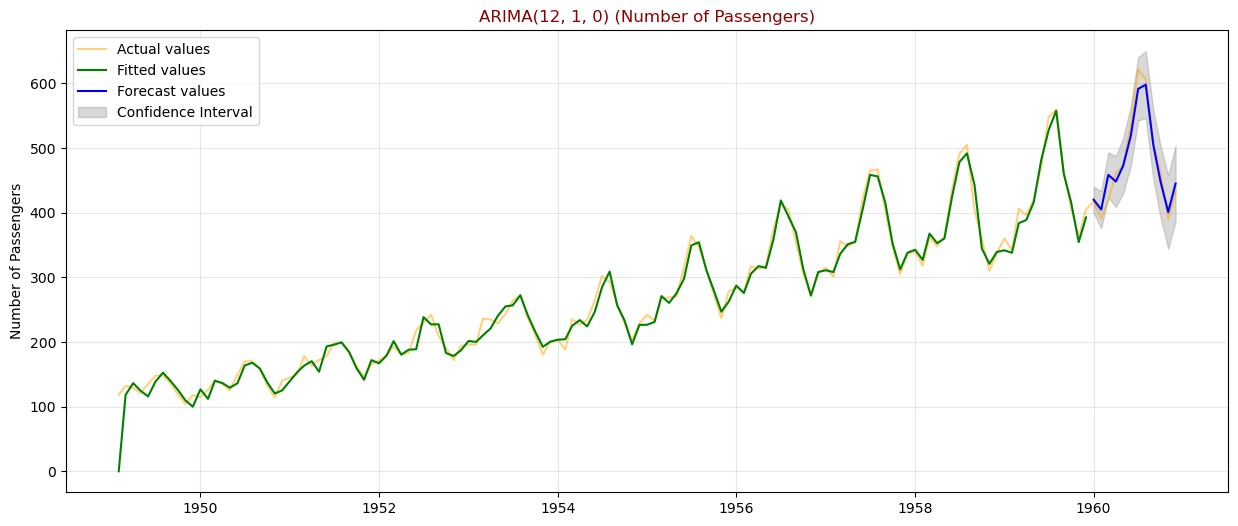

In [33]:
train_actual1, train_pred1, test_actual1, test_forecast1 = arima_split(df1.dropna(), 'Passengers', Ntest = 12, freq = 'MS',
                                                                   order=(12, 1, 0), y_name='Number of Passengers')

# Ntest = 12 is just an abtrary number for demonstration

* Looks fine. Let's def another function to calculate performance metrics.

In [36]:
def evaluate_model(y_true, y_pred, is_logged = False):
    """
    Calculate common metrics to evaluate a model.
    
    Args:
        y_true: Array or list of actual values.
        y_pred: Array or list of predicted values.
        is_logged: if the data has been transformed by log, then reverting back to the original unit
        
    Returns:
        A dictionary with common metrics: MAE, MSE, RMSE, MAPE, R².
    """
    if is_logged == True:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    else:
        y_true =  y_true
        y_pred =  y_pred
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # R-squared (R²)
    r2 = r2_score(y_true, y_pred)
    
    # Return the metrics in a dictionary
    return {
        'MAE': round(mae,6),
        'MSE': round(mse,6),
        'RMSE': round(rmse,6),
        'MAPE': round(mape,6),
        'R²': round(r2, 6) }

In [42]:
evaluate_model(train_actual1, train_pred1)

{'MAE': 9.345064,
 'MSE': 220.687788,
 'RMSE': 14.855564,
 'MAPE': 4.373756,
 'R²': 0.980287}

In [46]:
evaluate_model(test_actual1, test_forecast1)

{'MAE': 13.782375,
 'MSE': 306.017228,
 'RMSE': 17.493348,
 'MAPE': 2.939094,
 'R²': 0.944757}

* Now let's move to using Auto SARIMA to see if we can get a better model.

## Auto SARIMA

In [50]:
df2 = pd.read_csv('airline_passengers.csv', index_col =  'Month', parse_dates = True) # still this dataset

* Using the ACF, PACF above as a skimming test, m = 12 is a good candidate for the Auto Seasonal ARIMA model.

In [56]:
def auto_sarima_split(df: pd.DataFrame, data_col: str, Ntest: int, freq =  'MS',
                     seasonal=True, m=12, 
                     stepwise=True, y_name='Number of Passengers'):
    """
    Function to perform Auto SARIMA(p, d, q)(P, D, Q)[m] with train-test split, where Ntest is the number
    of steps for test. Outputs model summary and a plot of actual vs fitted vs forecast.
    
    Parameters:
    - df: DataFrame containing the time series data
    - data_col: Column name of the time series data in the DataFrame
    - Ntest: Number of test periods to split from the data
    - seasonal: Boolean indicating whether to fit a seasonal ARIMA model
    - m: Number of periods in a seasonal cycle
    - stepwise: Boolean; if False, do full grid search
    - y_name: Label for the y-axis in the plot
    
    Outputs:
    - Model summary
    - Plot of actual, fitted, and forecasted values
    - Returns the actual and forecasted values for further evaluation
    """
    df.index.freq = freq

    # Split the data into train and test sets
    train = df.iloc[:-Ntest]
    test = df.iloc[-Ntest:]
    
    # Fit the Auto ARIMA model
    model = pm.auto_arima(train[data_col], 
                          trace=True, 
                          suppress_warnings=True,
                          seasonal=seasonal, 
                          m=m, 
                          stepwise=stepwise,
                          max_p= 15, max_q=10, max_order=25)
    
    # Output the model summary
    print(model.summary())
    
    # Plot the actual values
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(df.index, df[data_col], label='Actual data', color='orange', alpha = 0.5)

    # Get the differencing order `d` from the model
    d = model.order[1]  # Differencing order

    # Get in-sample fitted values (train predictions)
    train_prediction = model.predict_in_sample(start=d, end=len(train) - 1)

    # Plot fitted values for training data
    ax.plot(train.index[d:], train_prediction, label='Fitted values', color='green')

    # Make forecast for the test period
    test_forecast, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    # Plot forecasted values for test period
    ax.plot(test.index, test_forecast, label='Forecast', color='blue')
    
    # Plot confidence interval
    ax.fill_between(test.index, confint[:, 0], confint[:, 1], color='grey', alpha=0.3)

    # Add plot labels and legend
    ax.legend(loc='best')
    ax.set_title(f'Auto ARIMA: Actual vs Fitted vs Forecast ({y_name})', color='darkred')
    ax.set_ylabel(y_name)
    ax.grid(True, alpha=0.3)
    
    # Show the plot
    plt.show()

    # Adjust `actual_train` to match the length of `train_prediction`
    actual_train = train[data_col].iloc[d:]  # Start from index `d` to match `train_prediction`
    
    # Return actual train, train predictions, actual test values, and test forecasts for evaluation
    actual_test = test[data_col]
    return actual_train, train_prediction, actual_test, test_forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=0.52 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.14 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.09 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.25 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.05 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.21 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

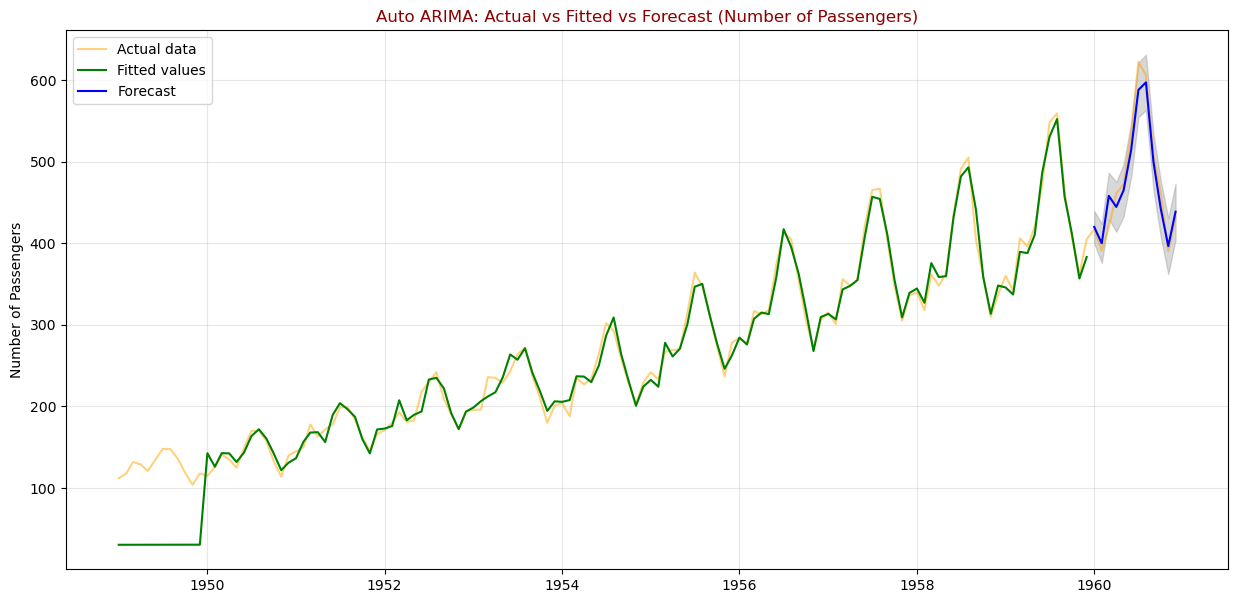

In [60]:
train_actual2, train_pred2, test_actual2, test_pred2 = auto_sarima_split(df2.dropna(), 'Passengers', 
                                                                            Ntest = 12,
                                                                            seasonal=True, m=12, 
                                                                            y_name='Number of Passengers')
# Here the Auto SARIMA model will identify the optimal d so we don't need to apply differencing

* The best Auto SARIMA model using m = 12 is (3, 0, 0)(0, 1, 0)[12]

In [63]:
evaluate_model(train_actual2, train_pred2)

{'MAE': 16.01031,
 'MSE': 949.901688,
 'RMSE': 30.820475,
 'MAPE': 9.796279,
 'R²': 0.915811}

In [65]:
evaluate_model(test_actual2, test_pred2)

{'MAE': 14.898208,
 'MSE': 343.600677,
 'RMSE': 18.536469,
 'MAPE': 3.097562,
 'R²': 0.937972}

* In terms of R2, these are not superior compared to the ARIMA(12, 1, 0) model above.

In [68]:
df2['LogPassengers'] = np.log(df2.Passengers) # Let's try some log transformation

In [70]:
difference_until_pass_kpss(df2['LogPassengers']) # just to check

Series became stationary after 1 differencing(s).


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-440.388, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-317.949, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-433.027, Time=0.57 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-383.189, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-134.983, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-444.326, Time=1.03 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-414.783, Time=0.23 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-442.330, Time=1.64 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-436.714, Time=0.86 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-445.572, Time=0.67 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-414.732, Time=0.09 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-439.509, Time=0.80 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-443.555, Time=1.35 sec
 ARIMA(1,0,2)(1,1,0)[12]

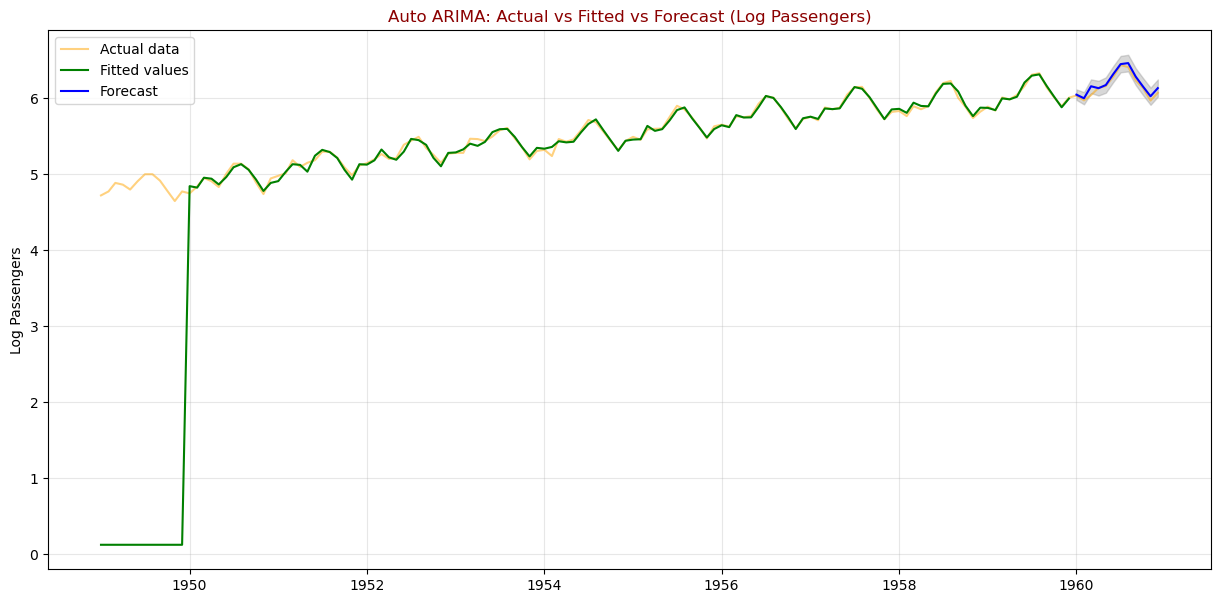

In [72]:
train_actual3, train_pred3, test_actual3, test_pred3 =  auto_sarima_split(df2.dropna(), 'LogPassengers', 
                                                                            Ntest = 12, 
                                                                            seasonal=True, m=12, 
                                                                            y_name='Log Passengers')

# Try again with log data to see if we can improve the model

In [74]:
evaluate_model(train_actual3, train_pred3, is_logged = True) # note the parameters is_logged

{'MAE': 17.742597,
 'MSE': 1524.951506,
 'RMSE': 39.050627,
 'MAPE': 11.516609,
 'R²': 0.864844}

In [76]:
evaluate_model(test_actual3, test_pred3, is_logged = True)

{'MAE': 18.32176,
 'MSE': 531.033662,
 'RMSE': 23.044168,
 'MAPE': 3.948949,
 'R²': 0.904136}

* So they are not superior compared to our very first model ARIMA(12, 1, 0).

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1277.589, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1264.738, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1262.608, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,7)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,8)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,9)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,10)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1268.313, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1258.440, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 se

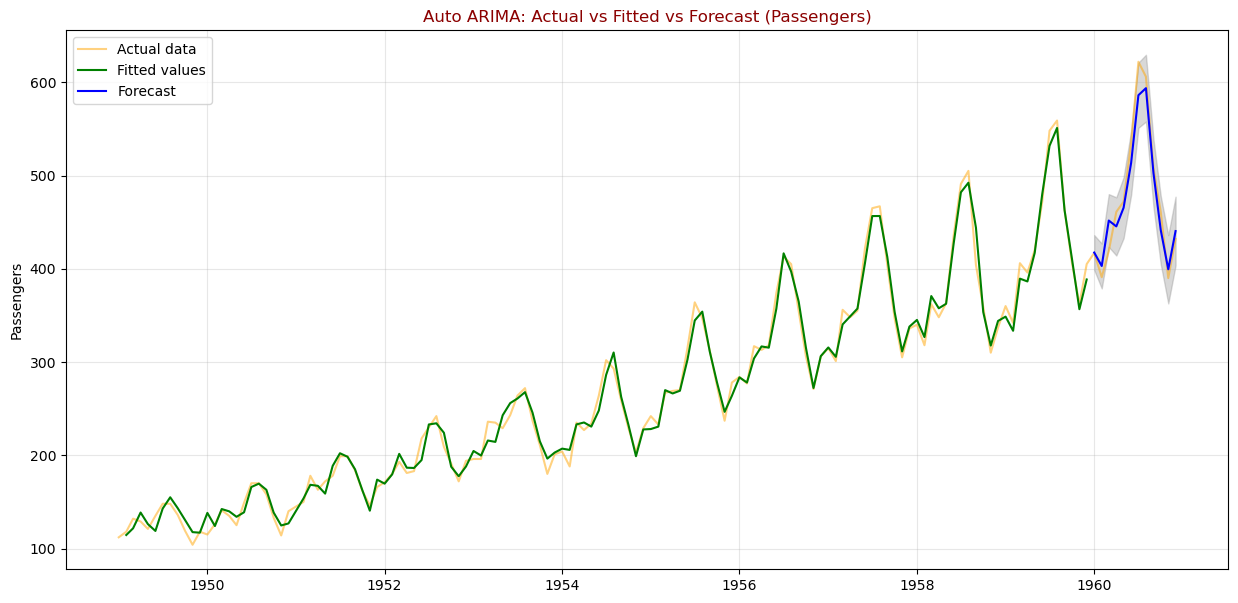

In [79]:
train_actual4, train_pred4, test_actual4, test_pred4 = auto_sarima_split(df2, 'Passengers', 
                                                                            Ntest = 12, 
                                                                            seasonal=False,
                                                                            stepwise = False, # Full Grid Search
                                                                            y_name='Passengers')
# Let's remove seasonal assumption and try Full Grid Search on both non-logged and logged data

* The best model here is ARIMA(14, 1, 1). Let's check its performance metrics.

In [82]:
evaluate_model(train_actual4, train_pred4)

{'MAE': 7.746827,
 'MSE': 98.259867,
 'RMSE': 9.912612,
 'MAPE': 3.385423,
 'R²': 0.991223}

In [84]:
evaluate_model(test_actual4, test_pred4)

{'MAE': 14.969064,
 'MSE': 330.736625,
 'RMSE': 18.186166,
 'MAPE': 3.100583,
 'R²': 0.940295}

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-211.983, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-216.493, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=-261.214, Time=0.12 sec
 ARIMA(0,1,7)(0,0,0)[0] intercept   : AIC=-260.014, Time=0.15 sec
 ARIMA(0,1,8)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,9)(0,0,0)[0] intercept   : AIC=-265.379, Time=0.30 sec
 ARIMA(0,1,10)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-214.718, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-221.069, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-252.22

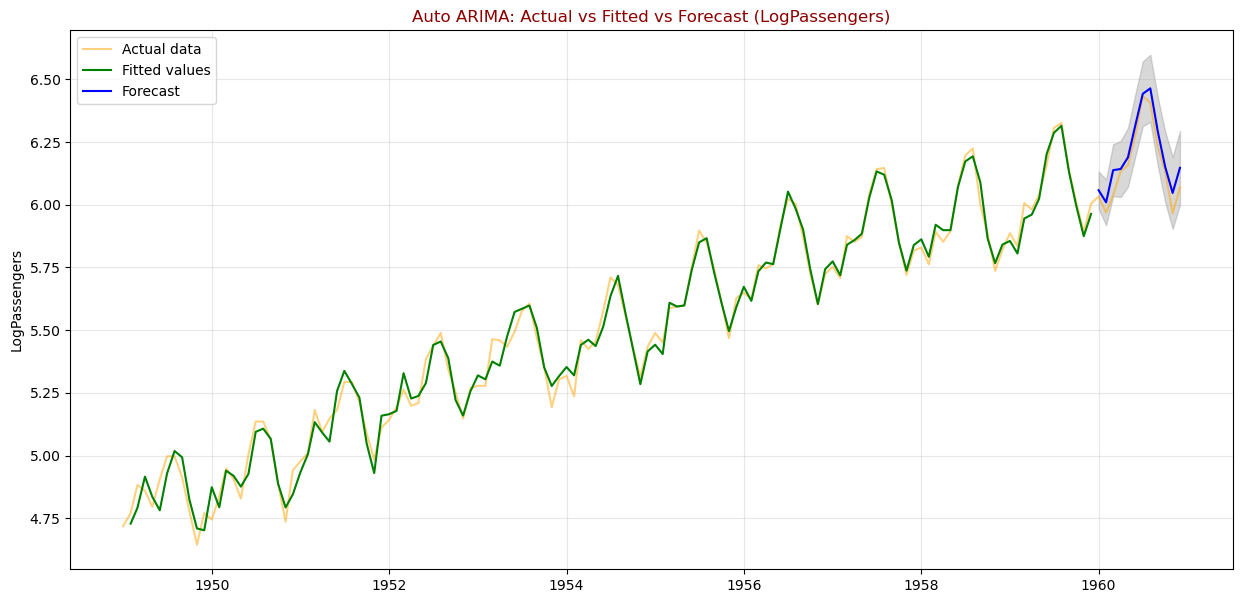

In [86]:
train_actual5, train_pred5, test_actual5, test_pred5 = auto_sarima_split(df2, 'LogPassengers', 
                                                                            Ntest = 12, 
                                                                            seasonal=False,
                                                                            stepwise = False, # Full Grid Search
                                                                            y_name='LogPassengers')

In [88]:
evaluate_model(train_actual5, train_pred5, is_logged = True)

{'MAE': 7.864719,
 'MSE': 97.14651,
 'RMSE': 9.856293,
 'MAPE': 3.371767,
 'R²': 0.991322}

In [90]:
evaluate_model(test_actual5, test_pred5, is_logged = True)

{'MAE': 21.736753,
 'MSE': 641.770375,
 'RMSE': 25.333187,
 'MAPE': 4.726859,
 'R²': 0.884146}

* Although the real practice should be more thorough, by these examples, we can see that:
1) By applying fundamental techniques of Stationarity Test, ACF, PACF plot, we can still choose a decent model compared to the Auto processes.
2) More practice can be done by comparing these to the Naive forecast model.
3) More practice can be done by implement by applying more sophisticated techniques.